In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'

In [2]:
from utils import *

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

# path for dataset (will be not there after end of session)
path_data = "./data"
path_logs = "./logs"

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Dataloaders

In [5]:
BATCH_SIZE = 32
augment = False
random_seed = 1

train_loader, valid_loader = get_train_valid_loader(path_data,
                           BATCH_SIZE,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=1,
                           pin_memory=True)

dataloaders = {"train": train_loader, 
               "val": valid_loader}

test_loader = get_test_loader(path_data,
                    BATCH_SIZE,
                    shuffle=True,
                    num_workers=1,
                    pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Simple convolutional Net

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

In [9]:
best_model, val_acc_history, plot_df = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25)

Epoch 0/24 	Train loss: 1.6094 acc: 0.4136 		 Val loss: 1.5369 acc: 0.4594
Epoch 1/24 	Train loss: 1.3425 acc: 0.5153 		 Val loss: 1.3106 acc: 0.5274
Epoch 2/24 	Train loss: 1.2124 acc: 0.5652 		 Val loss: 1.3104 acc: 0.5308
Epoch 3/24 	Train loss: 1.1164 acc: 0.6046 		 Val loss: 1.2425 acc: 0.5610
Epoch 4/24 	Train loss: 1.0413 acc: 0.6303 		 Val loss: 1.1388 acc: 0.5958
Epoch 5/24 	Train loss: 0.9777 acc: 0.6526 		 Val loss: 1.1993 acc: 0.5800
Epoch 6/24 	Train loss: 0.9253 acc: 0.6721 		 Val loss: 1.0925 acc: 0.6220
Epoch 7/24 	Train loss: 0.8766 acc: 0.6892 		 Val loss: 1.1427 acc: 0.5998
Epoch 8/24 	Train loss: 0.8317 acc: 0.7037 		 Val loss: 1.2557 acc: 0.5858
Epoch 9/24 	Train loss: 0.7934 acc: 0.7171 		 Val loss: 1.1744 acc: 0.6122
Epoch 10/24 	Train loss: 0.7583 acc: 0.7307 		 Val loss: 1.1629 acc: 0.6154
Epoch 11/24 	Train loss: 0.7243 acc: 0.7425 		 Val loss: 1.1904 acc: 0.6164
Epoch 12/24 	Train loss: 0.6907 acc: 0.7537 		 Val loss: 1.1705 acc: 0.6226
Epoch 13/24 	Train los

In [10]:
val_acc_history.head(3).append(val_acc_history.tail(3))

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,1.609387,0.413600,1.536931,0.4594
1,1,1.342515,0.515311,1.310567,0.5274
2,2,1.212362,0.565222,1.310430,0.5308
22,22,0.455955,0.835978,1.626504,0.6094
23,23,0.439270,0.840667,1.672926,0.6124
24,24,0.421780,0.848400,1.665059,0.6074


In [11]:
val_acc_history.to_csv(path_logs+"/EXP03.csv", index=None)

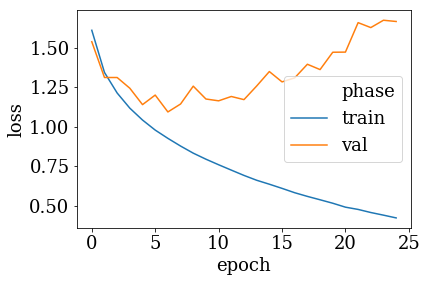

In [12]:
s = sns.lineplot(x='epoch', y='loss', data=plot_df, hue='phase')

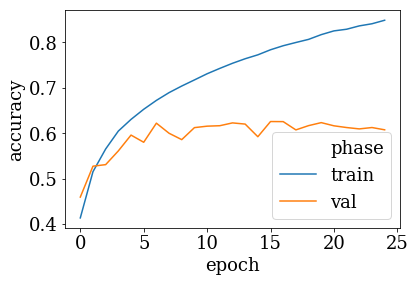

In [13]:
s = sns.lineplot(x='epoch', y='accuracy', data=plot_df, hue='phase')

In [14]:
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Accuracy of the network on the 10000 test images: 62.15 %


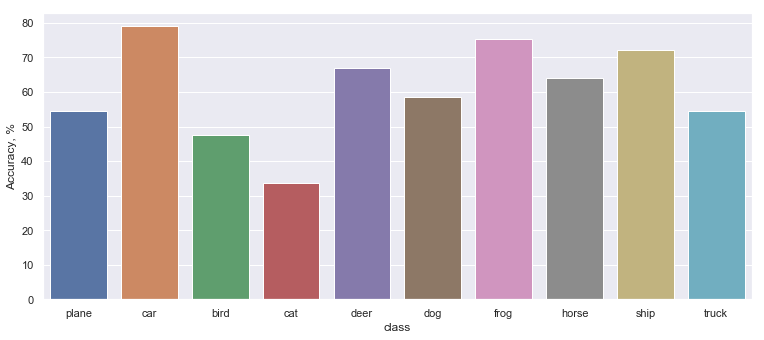

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = best_model(images.to('cuda'))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cuda') == labels.to('cuda')).sum().item()

print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = best_model(images.to('cuda'))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.to('cuda') == labels.to('cuda')).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
acc_res_num = 100*np.array(class_correct) / np.array(class_total)
acc_res_df = pd.DataFrame({"class": classes, "Accuracy, %": acc_res_num})
sns.set(rc={'figure.figsize':(12.7,5.27)})
s = sns.barplot(x='class', y='Accuracy, %', data=acc_res_df)

In [16]:
acc_res = [str(round(v, 2))+"%" for v in acc_res_num]
acc_res_df_per = pd.DataFrame({"class": classes, "Accuracy, %": acc_res})
acc_res_df_per

,class,"Accuracy, %"
0,plane,54.63%
1,car,78.95%
2,bird,47.55%
3,cat,33.58%
4,deer,66.94%
5,dog,58.59%
6,frog,75.21%
7,horse,64.0%
8,ship,72.03%
9,truck,54.55%
